In [1]:
# https://github.com/fatiando/pooch
from pathlib import Path
import pooch

IMAGE_FILE_NAME = "TS_01_020_30.0.mrc"
GOODBOY = pooch.create(
    path=pooch.os_cache("torch-ctf-estimation"),
    base_url="doi:10.5281/zenodo.15620931/",
    registry={
        IMAGE_FILE_NAME: "md5:598e9c439543c85529e64bca1adc325a",
    },
)

image_file = Path(GOODBOY.fetch(IMAGE_FILE_NAME, progressbar=True))
pixel_spacing = 0.675

100%|████████████████████████████████████████| 456M/456M [00:00<00:00, 367GB/s]


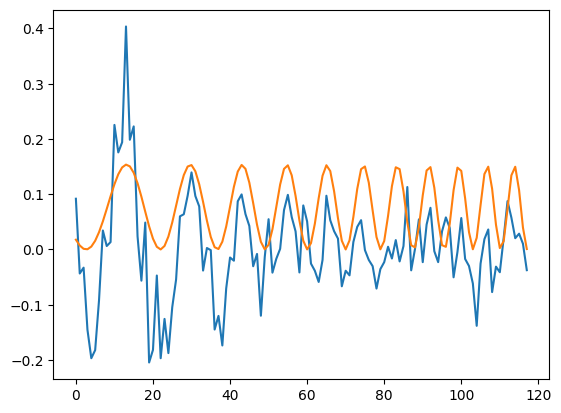

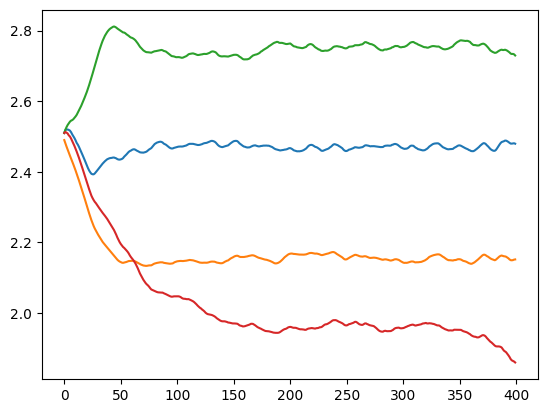

In [2]:
import torch
import mrcfile

from torch_ctf_estimation import estimate_ctf
from torch_fourier_rescale import fourier_rescale_2d

image = mrcfile.read(image_file)
image = torch.tensor(image).float()
image, _ = fourier_rescale_2d(image, source_spacing=pixel_spacing, target_spacing=1.35)

defocus_grid = estimate_ctf(
    image=image,
    pixel_spacing_angstroms=1.35,
    defocus_grid_resolution=(1, 2, 2),
    frequency_fit_range_angstroms=(30, 8),
    defocus_range_microns=(2, 8),
    voltage_kev=300,
    spherical_aberration_mm=2.7,
    amplitude_contrast_fraction=0.07,
    patch_sidelength=512,
    plot=True,
)


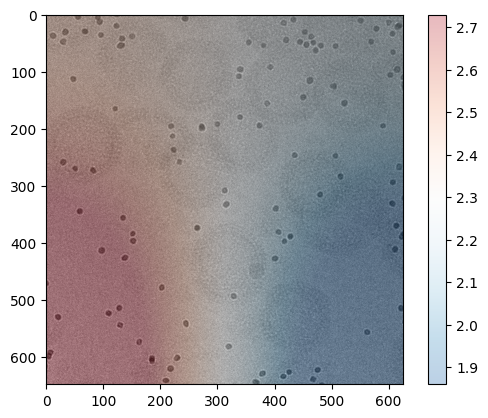

In [4]:
from matplotlib import pyplot as plt
from cmap import Colormap

image_downscaled, _ = fourier_rescale_2d(
    image=image, source_spacing=1.35, target_spacing=8

)
image_downscaled = image_downscaled.mean(dim=0)

fig, ax = plt.subplots()
ax.imshow(image_downscaled.numpy(), cmap='gray')
cm = Colormap('tol:BuRd').to_mpl()
h, w = image_downscaled.shape
defocus_image = defocus_grid.reshape((2, 2)).detach().numpy()
pos = ax.imshow(
    defocus_image,
    extent=(-0.5, w-0.5, h-0.5, -0.5),
    alpha=0.3,
    interpolation='spline36',
    cmap=cm
)
plt.colorbar(pos, ax=ax)
plt.show()